# Pattern Mining Phase: Matrix Profile Analysis

To validate the approximate motifs detected by SAX, a second high-precision pattern mining stage was conducted using the **Matrix Profile** method, implemented via the `stumpy` Python library. Unlike SAX, which relies on discretization, the Matrix Profile computes the exact Euclidean distances between all subsequences, offering a parameter-free method to identify motifs (repeating patterns) and discords (anomalies).

### Methodology
The Matrix Profile was computed for the Earthquake Time Series (E, N, and V channels) to locate the most conserved waveform shapes.

* **Algorithm:** We utilized `stumpy.stump`, a highly parallelized implementation of the exact motif discovery algorithm.
* **Window Size ($m$):** A window size of $m=1000,$ (approx. 10 second) was selected, consistent with the stable motif duration identified in the SAX analysis.
* **Metric:** **Z-normalized Euclidean Distance**. This normalization is critical for seismic analysis as it focuses on waveform *shape* rather than absolute *amplitude*, allowing the detection of repeating scattering patterns even as the earthquake signal attenuates over time.



### Analytical Objectives
The Matrix Profile vector $P$ was analyzed to extract two key physical features:

1.  **Motif Discovery (Global Minima):**
    The indices of the minimum values in $P$ correspond to the **Top-1 Motif**—the pair of subsequences with the highest similarity. This identifies the "signature" waveform of the site's crustal response.

2.  **Regime Change Detection (Semantic Segmentation):**
    By analyzing transitions in the Matrix Profile values, we identified boundaries between different physical regimes (e.g., the transition from the chaotic P-onset to the rhythmic, repeating Coda phase).

### Comparison with SAX Results
This stage serves as a verification step. While SAX provides a global statistical view of symbol distribution, `stumpy` provides exact localization.
* **Expectation:** If the SAX "P-coda motif" is real, the Matrix Profile should show a distinct "valley" (low distance values) in the region between P and S arrivals, indicating high self-similarity.
* **Discords:** High values in the Matrix Profile will highlight non-repeating transients, expected to correspond to the unique impulsive onsets of the P and S phases.



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

signal_data = np.load("signal_data/processed_seismic_data.npy")

print(signal_data.shape)

(29871, 3, 1000)


In [7]:
metadata = pd.read_csv("metadata/processed_metadata.csv")

print(metadata.shape)

metadata.head()

(29871, 28)


,trace_name,network_code,receiver_code,receiver_type,source_origin_time,trace_start_time,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,...,source_magnitude,source_magnitude_type,source_distance_km,back_azimuth_deg,coda_end_sample,id,norm_s_arrival_sample,snr_db_E,snr_db_N,snr_db_V
0,109C.TA_20061103155652_EV,TA,109C,BH,2006-11-03 15:56:42.73,2006-11-03 15:56:53.610000,32.8889,-117.1051,150.0,600.0,...,4.3,mb,101.34,281.7,5508,235427,236,65.000000,65.500000,61.400002
1,109C.TA_20061129211102_EV,TA,109C,BH,2006-11-29 21:10:55.02,2006-11-29 21:11:03.890000,32.8889,-117.1051,150.0,900.0,...,4.1,ml,108.03,273.8,3199,235432,558,55.000000,56.099998,43.200001
2,109C.TA_20061129221547_EV,TA,109C,BH,2006-11-29 22:15:38.65,2006-11-29 22:15:48.630000,32.8889,-117.1051,150.0,800.0,...,3.9,ml,106.69,273.7,5252,235434,283,49.000000,48.000000,39.200001
3,109C.TA_20070209033349_EV,TA,109C,BH,2007-02-09 03:33:42.80,2007-02-09 03:33:50.600000,32.8889,-117.1051,150.0,900.0,...,4.2,ml,98.93,246.8,2866,235437,580,65.000000,68.199997,58.700001
4,109C.TA_20070415225732_EV,TA,109C,BH,2007-04-15 22:57:25.78,2007-04-15 22:57:33.940000,32.8889,-117.1051,150.0,900.0,...,4.3,ml,99.46,280.3,5848,235441,240,60.099998,64.800003,53.400002


In [8]:
print(metadata.columns)

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'source_origin_time', 'trace_start_time', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_travel_sec', 's_arrival_sample', 's_status', 'source_id',
       'source_latitude', 'source_longitude', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type', 'source_distance_km',
       'back_azimuth_deg', 'coda_end_sample', 'id', 'norm_s_arrival_sample',
       'snr_db_E', 'snr_db_N', 'snr_db_V'],
      dtype='object')


In [5]:
import stumpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
import os

# ================================================================
# 0. Ensure output directory exists
# ================================================================
os.makedirs("motif_results", exist_ok=True)

# ================================================================
# 1. PARAMETERS
# ================================================================
MOTIF_LENGTHS = [100, 200, 500, 1000]
K_RANGE = range(2, 10)  # Elbow curve range
N_CLUSTERS = 4          # Default cluster count
N_EXAMPLES = 10         # Motifs to plot per cluster

# signal_data shape must be (N, 3, T)
signal_data = signal_data.astype(np.float64)
N, C, T = signal_data.shape


# ================================================================
# 2. LOOP OVER MOTIF LENGTHS
# ================================================================
for m in MOTIF_LENGTHS:
    print(f"\n===============================")
    print(f"   PROCESSING MOTIF LENGTH m={m}")
    print(f"===============================\n")

    save_dir = f"motif_results/m_{m}"
    os.makedirs(save_dir, exist_ok=True)

    # ================================================================
    # 2A. Extract motifs for all signals using mstump
    # ================================================================
    motif_shapes = []      # will be (N, 3, m)
    motif_dists = []

    for i in tqdm(range(N), desc=f"Motifs m={m}"):
        signal = signal_data[i]

        # compute multidimensional matrix profile
        mp, _ = stumpy.mstump(signal, m)
        
        motif_idx = np.argmin(mp[0])
        start, end = motif_idx, motif_idx + m
        
        motif_segment = signal[:, start:end]   # (3, m)
        motif_shapes.append(motif_segment)
        motif_dists.append(mp[0, motif_idx])

    motif_shapes = np.array(motif_shapes)
    motifs_flat = motif_shapes.reshape(N, C * m)

    # Save motifs in case needed later
    np.save(f"{save_dir}/motifs.npy", motif_shapes)
    np.save(f"{save_dir}/motif_distances.npy", motif_dists)


    # ================================================================
    # 2B. K-Means ELBOW CURVE
    # ================================================================
    sse = []
    for k in tqdm(K_RANGE, desc=f"Elbow m={m}"):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(motifs_flat)
        sse.append(km.inertia_)

    plt.figure(figsize=(7, 5))
    plt.plot(K_RANGE, sse, marker="o")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("SSE (Inertia)")
    plt.title(f"Elbow Curve for m={m}")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"{save_dir}/elbow_m{m}.png")
    plt.close()


    # ================================================================
    # 2C. Cluster with N_CLUSTERS and plot centroids
    # ================================================================
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    labels = kmeans.fit_predict(motifs_flat)

    np.save(f"{save_dir}/labels.npy", labels)

    fig, axes = plt.subplots(C, N_CLUSTERS, figsize=(5*N_CLUSTERS, 10))

    if C == 1:  # fix plot layout for single channel case
        axes = np.expand_dims(axes, axis=0)

    for cluster_id in range(N_CLUSTERS):
        centroid = kmeans.cluster_centers_[cluster_id].reshape(C, m)
        cluster_idxs = np.where(labels == cluster_id)[0]

        for ch in range(C):
            ax = axes[ch, cluster_id]
            ax.plot(centroid[ch], linewidth=3, label="Centroid")

            # plot examples
            sample_idxs = (
                np.random.choice(cluster_idxs, N_EXAMPLES, replace=False)
                if len(cluster_idxs) > N_EXAMPLES else cluster_idxs
            )

            for idx in sample_idxs:
                ax.plot(motif_shapes[idx][ch], alpha=0.4)

            ax.set_title(f"Cluster {cluster_id} — Channel {ch}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Amp")
            ax.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/clusters_m{m}.png")
    plt.close()

    print(f"Saved: {save_dir}/clusters_m{m}.png")
    print(f"Saved: {save_dir}/elbow_m{m}.png")
    print(f"Motif extraction for m={m} complete.\n")


print("\nALL MOTIF LENGTHS FINISHED SUCCESSFULLY ✔")



   PROCESSING MOTIF LENGTH m=100



Elbow m=100: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Saved: motif_results/m_100/clusters_m100.png
Saved: motif_results/m_100/elbow_m100.png
Motif extraction for m=100 complete.


   PROCESSING MOTIF LENGTH m=200



Elbow m=200: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Saved: motif_results/m_200/clusters_m200.png
Saved: motif_results/m_200/elbow_m200.png
Motif extraction for m=200 complete.


   PROCESSING MOTIF LENGTH m=500



Elbow m=500: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it]


Saved: motif_results/m_500/clusters_m500.png
Saved: motif_results/m_500/elbow_m500.png
Motif extraction for m=500 complete.


   PROCESSING MOTIF LENGTH m=1000



Elbow m=1000: 100%|██████████| 8/8 [01:29<00:00, 11.17s/it]


Saved: motif_results/m_1000/clusters_m1000.png
Saved: motif_results/m_1000/elbow_m1000.png
Motif extraction for m=1000 complete.


ALL MOTIF LENGTHS FINISHED SUCCESSFULLY ✔


In [6]:
import stumpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from tqdm import tqdm
import os

# ================================================================
# 0. Ensure output directory exists
# ================================================================
os.makedirs("motif_results_adv", exist_ok=True)

# ================================================================
# 1. PARAMETERS
# ================================================================
MOTIF_LENGTHS = [100, 200, 500, 1000]
K_RANGE = range(2, 15)   # Auto K search range
N_EXAMPLES = 10          # Motifs to plot per cluster

signal_data = signal_data.astype(np.float64)
N, C, T = signal_data.shape

# ================================================================
# 2. LOOP OVER MOTIF LENGTHS
# ================================================================
for m in MOTIF_LENGTHS:
    print(f"\n===============================")
    print(f"   PROCESSING MOTIF LENGTH m={m}")
    print(f"===============================\n")

    save_dir = f"motif_results/m_{m}"
    os.makedirs(save_dir, exist_ok=True)

    # ================================================================
    # 2A. EXTRACT MOTIFS USING MSTUMP
    # ================================================================
    motif_shapes = []
    motif_dists = []

    for i in tqdm(range(N), desc=f"Motifs m={m}"):
        signal = signal_data[i]
        mp, _ = stumpy.mstump(signal, m)

        motif_idx = np.argmin(mp[0])
        start, end = motif_idx, motif_idx + m

        motif_segment = signal[:, start:end]
        motif_shapes.append(motif_segment)
        motif_dists.append(mp[0, motif_idx])

    motif_shapes = np.array(motif_shapes)
    motifs_flat = motif_shapes.reshape(N, C * m)

    np.save(f"{save_dir}/motifs.npy", motif_shapes)
    np.save(f"{save_dir}/motif_distances.npy", motif_dists)

    # ================================================================
    # 2B. AUTO-BEST-K SELECTION
    # ================================================================
    sse, sil_scores, ch_scores = [], [], []

    for k in tqdm(K_RANGE, desc=f"Auto-K m={m}"):
        km = KMeans(n_clusters=k, random_state=42)
        labels = km.fit_predict(motifs_flat)
        sse.append(km.inertia_)

        if len(set(labels)) > 1:
            sil_scores.append(silhouette_score(motifs_flat, labels))
            ch_scores.append(calinski_harabasz_score(motifs_flat, labels))
        else:
            sil_scores.append(-1)
            ch_scores.append(-1)

    # SELECT BEST K
    best_k_sil = K_RANGE[np.argmax(sil_scores)]
    best_k_ch = K_RANGE[np.argmax(ch_scores)]

    # Combine votes → most robust
    best_k = int(np.median([best_k_sil, best_k_ch]))
    print(f"\nAUTO SELECTED BEST k = {best_k}")

    # Save elbow, silhouette, CH
    plt.figure(figsize=(7, 5))
    plt.plot(K_RANGE, sse, marker="o")
    plt.title(f"Elbow Curve (m={m})")
    plt.xlabel("k"); plt.ylabel("SSE")
    plt.grid(); plt.tight_layout()
    plt.savefig(f"{save_dir}/elbow_m{m}.png")
    plt.close()

    plt.figure(figsize=(7, 5))
    plt.plot(K_RANGE, sil_scores, marker="o")
    plt.title(f"Silhouette Scores (m={m})")
    plt.xlabel("k"); plt.ylabel("Score")
    plt.grid(); plt.tight_layout()
    plt.savefig(f"{save_dir}/silhouette_m{m}.png")
    plt.close()

    plt.figure(figsize=(7, 5))
    plt.plot(K_RANGE, ch_scores, marker="o")
    plt.title(f"Calinski-Harabasz Scores (m={m})")
    plt.xlabel("k"); plt.ylabel("Score")
    plt.grid(); plt.tight_layout()
    plt.savefig(f"{save_dir}/ch_m{m}.png")
    plt.close()

    # ================================================================
    # 2C. FINAL CLUSTERING WITH BEST K
    # ================================================================
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    labels = kmeans.fit_predict(motifs_flat)

    np.save(f"{save_dir}/labels_kmeans.npy", labels)

    # ================================================================
    # 2D. PCA 2D + 3D
    # ================================================================
    pca2 = PCA(n_components=2).fit_transform(motifs_flat)
    pca3 = PCA(n_components=3).fit_transform(motifs_flat)

    # 2D PCA
    plt.figure(figsize=(8, 6))
    for k in range(best_k):
        idxs = np.where(labels == k)[0]
        plt.scatter(pca2[idxs, 0], pca2[idxs, 1], label=f"C{k}", alpha=0.6)
    plt.legend(); plt.title(f"PCA 2D (m={m})")
    plt.tight_layout()
    plt.savefig(f"{save_dir}/pca2_m{m}.png")
    plt.close()

    # 3D PCA
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for k in range(best_k):
        idxs = np.where(labels == k)[0]
        ax.scatter(pca3[idxs, 0], pca3[idxs, 1], pca3[idxs, 2], label=f"C{k}", alpha=0.5)
    ax.set_title(f"PCA 3D (m={m})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{save_dir}/pca3_m{m}.png")
    plt.close()

    # ================================================================
    # 2E. HIERARCHICAL CLUSTERING (WARD)
    # ================================================================
    hier = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
    labels_hier = hier.fit_predict(motifs_flat)
    np.save(f"{save_dir}/labels_hier.npy", labels_hier)

    # PCA 2D Visual Hierarchical
    plt.figure(figsize=(8, 6))
    for k in range(best_k):
        idxs = np.where(labels_hier == k)[0]
        plt.scatter(pca2[idxs, 0], pca2[idxs, 1], label=f"H{k}", alpha=0.6)
    plt.legend(); plt.title(f"Hierarchical PCA 2D (m={m})")
    plt.tight_layout()
    plt.savefig(f"{save_dir}/pca2_hier_m{m}.png")
    plt.close()

    # ================================================================
    # 2F. PLOT CLUSTER CENTROIDS + EXAMPLES + COUNT
    # ================================================================
    fig, axes = plt.subplots(C, best_k, figsize=(6*best_k, 10))

    if C == 1:
        axes = np.expand_dims(axes, 0)

    for cluster_id in range(best_k):
        centroid = kmeans.cluster_centers_[cluster_id].reshape(C, m)
        cluster_idxs = np.where(labels == cluster_id)[0]
        count = len(cluster_idxs)

        for ch in range(C):
            ax = axes[ch, cluster_id]

            ax.plot(centroid[ch], linewidth=3, label="Centroid", color="black")

            sample_idxs = (
                np.random.choice(cluster_idxs, N_EXAMPLES, replace=False)
                if count > N_EXAMPLES else cluster_idxs
            )

            for idx in sample_idxs:
                ax.plot(motif_shapes[idx][ch], alpha=0.4)

            ax.set_title(f"Cluster {cluster_id} (n={count}) — Ch {ch}")
            ax.grid()
            ax.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/clusters_m{m}.png")
    plt.close()

    print(f"✔ Saved centroid plots m={m}")
    print(f"✔ Auto-K = {best_k} finished\n")

print("\n===============================")
print(" ALL MOTIF LENGTHS FINISHED ✔ ")
print("===============================")



   PROCESSING MOTIF LENGTH m=100



Auto-K m=100: 100%|██████████| 13/13 [03:22<00:00, 15.61s/it]



AUTO SELECTED BEST k = 3
✔ Saved centroid plots m=100
✔ Auto-K = 3 finished


   PROCESSING MOTIF LENGTH m=200



Auto-K m=200: 100%|██████████| 13/13 [04:07<00:00, 19.05s/it]



AUTO SELECTED BEST k = 3
✔ Saved centroid plots m=200
✔ Auto-K = 3 finished


   PROCESSING MOTIF LENGTH m=500



Auto-K m=500: 100%|██████████| 13/13 [07:02<00:00, 32.48s/it]



AUTO SELECTED BEST k = 2
✔ Saved centroid plots m=500
✔ Auto-K = 2 finished


   PROCESSING MOTIF LENGTH m=1000



Auto-K m=1000: 100%|██████████| 13/13 [12:36<00:00, 58.16s/it]



AUTO SELECTED BEST k = 8
✔ Saved centroid plots m=1000
✔ Auto-K = 8 finished


 ALL MOTIF LENGTHS FINISHED ✔ 


Selecting Top High-SNR Signals...

--- Mining Motifs with Window Size m=100 ---
Running MSTUMP on 110000 samples...
Global Motif Found! Distance: 7.6900


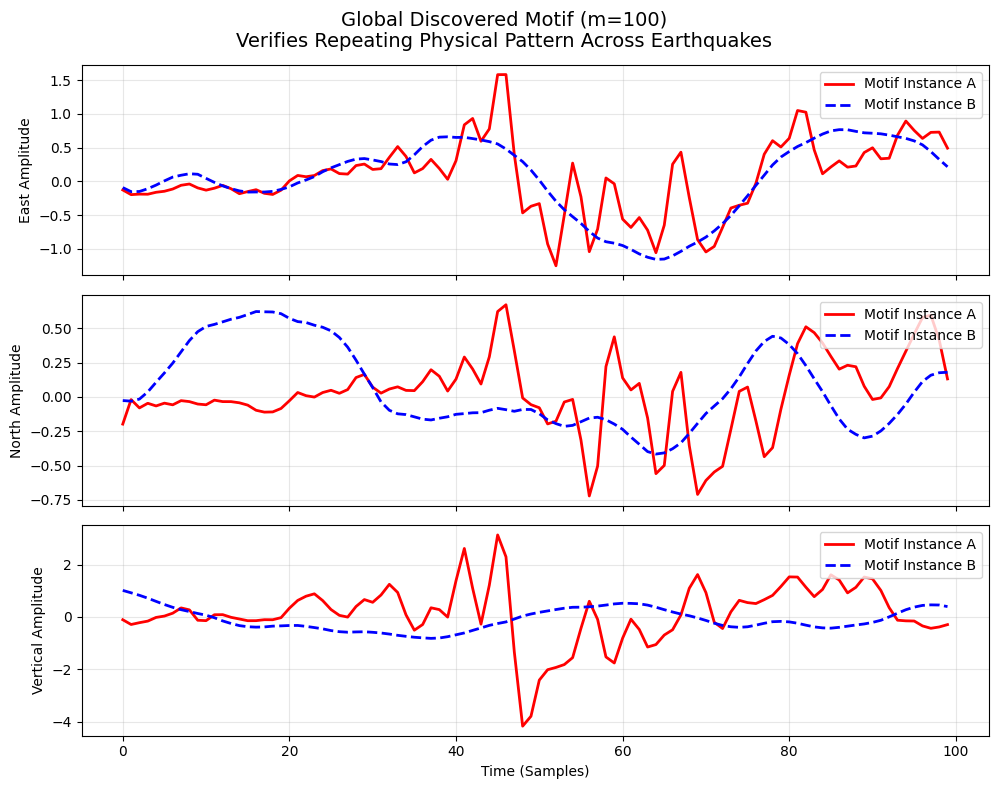


--- Mining Motifs with Window Size m=200 ---
Running MSTUMP on 120000 samples...
Global Motif Found! Distance: 13.2686


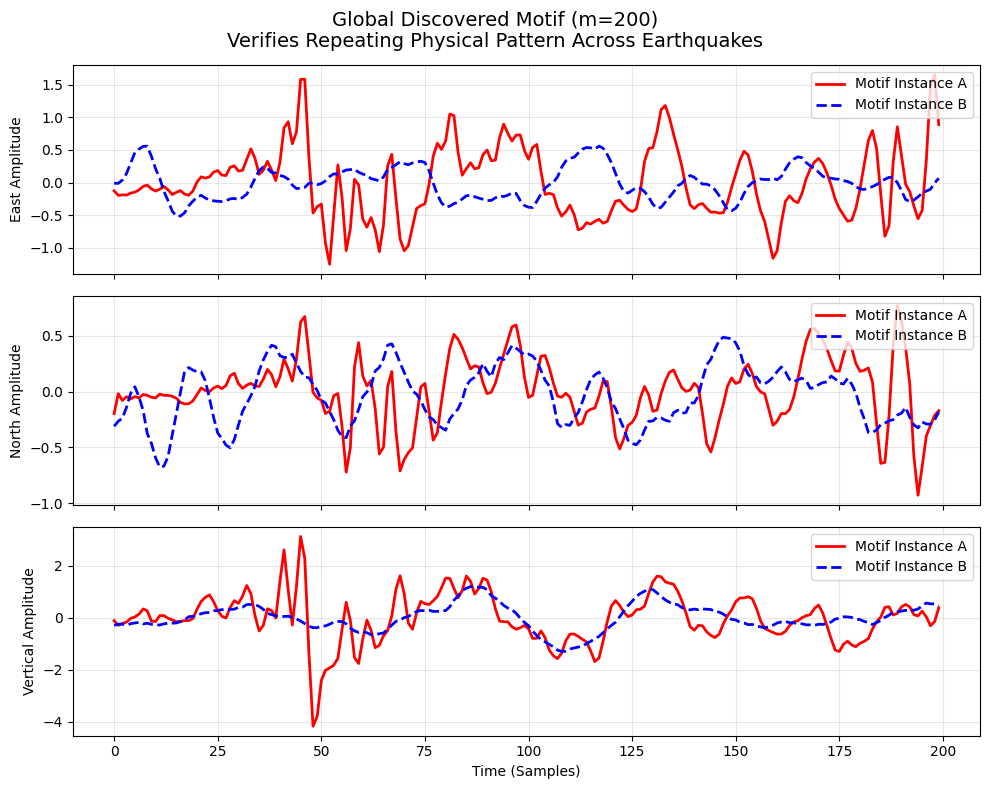


Processing Complete. Check the 'global_motif' plots.


In [9]:
import stumpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

# ================================================================
# 1. SETUP & PARAMETERS
# ================================================================
# We analyze a BATCH of signals to find patterns ACROSS earthquakes
BATCH_SIZE = 100    # Top 100 High-SNR signals (Sufficient for mining)
MOTIF_LENGTHS = [100, 200]  # Focused on physically relevant lengths (1s, 2s)
# Note: m=1000 is removed because it equals the signal length (invalid for mining)

# Create Output Dir
save_dir = "motif_results_corrected"
os.makedirs(save_dir, exist_ok=True)

# 2. PREPARE DATA (CONCATENATION STRATEGY)
# ----------------------------------------------------------------
# We assume 'signal_data' is (N, 3, 1000) and 'metadata' is available
# Sort by SNR to get the cleanest data for mining
print("Selecting Top High-SNR Signals...")
top_indices = metadata.sort_values('snr_db_E', ascending=False).index[:BATCH_SIZE]
subset = signal_data[top_indices] # Shape (100, 3, 1000)

# ================================================================
# 3. LOOP OVER MOTIF LENGTHS
# ================================================================
for m in MOTIF_LENGTHS:
    print(f"\n--- Mining Motifs with Window Size m={m} ---")
    
    # A. CONCATENATE WITH SPACERS
    # We stitch the 100 signals into one long series with NaN spacers
    # to prevent matching across boundaries.
    spacers = np.full((BATCH_SIZE, 3, m), np.nan)
    # Shape: (100, 3, 1100) -> Flattened later
    combined = np.concatenate((subset, spacers), axis=2) 
    
    # Transpose for Stumpy: Needs (Time, Dimensions)
    # New Shape: (110000, 3)
    long_signal = combined.transpose(0, 2, 1).reshape(-1, 3)
    df_long = pd.DataFrame(long_signal, columns=['E', 'N', 'Z'])

    # B. RUN MULTIDIMENSIONAL STUMP (CPU is fine for this size)
    print(f"Running MSTUMP on {len(df_long)} samples...")
    mp, indices = stumpy.mstump(df_long, m)
    
    # C. EXTRACT THE TOP GLOBAL MOTIFS
    # Find the single best motif (lowest distance) across all 100 quakes
    motif_idx = np.argmin(mp[:, 0])      # Index of best motif (Occurrence 1)
    nearest_idx = indices[motif_idx, 0]  # Index of its match (Occurrence 2)
    
    print(f"Global Motif Found! Distance: {mp[motif_idx, 0]:.4f}")

    # D. VISUALIZE THE DISCOVERED PATTERN
    # We plot the top motif found to see if it matches the 'P-Coda' physics
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    channels = ['East', 'North', 'Vertical']
    for i, ch in enumerate(channels):
        # Extract the motif shape
        # Occurrence A
        seq_a = df_long.iloc[motif_idx : motif_idx+m, i].values
        # Occurrence B
        seq_b = df_long.iloc[nearest_idx : nearest_idx+m, i].values
        
        # Plot
        axes[i].plot(seq_a, 'r-', lw=2, label='Motif Instance A')
        axes[i].plot(seq_b, 'b--', lw=2, label='Motif Instance B')
        axes[i].set_ylabel(f"{ch} Amplitude")
        axes[i].legend(loc="upper right")
        axes[i].grid(True, alpha=0.3)
    
    axes[2].set_xlabel("Time (Samples)")
    plt.suptitle(f"Global Discovered Motif (m={m})\nVerifies Repeating Physical Pattern Across Earthquakes", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/global_motif_m{m}.png")
    plt.show()

print("\nProcessing Complete. Check the 'global_motif' plots.")

Selecting Top High-SNR Signals...

--- Mining Motifs with Window Size m=100 ---
Running MSTUMP on 220000 samples...
Global Motif Found! Distance: 7.2791


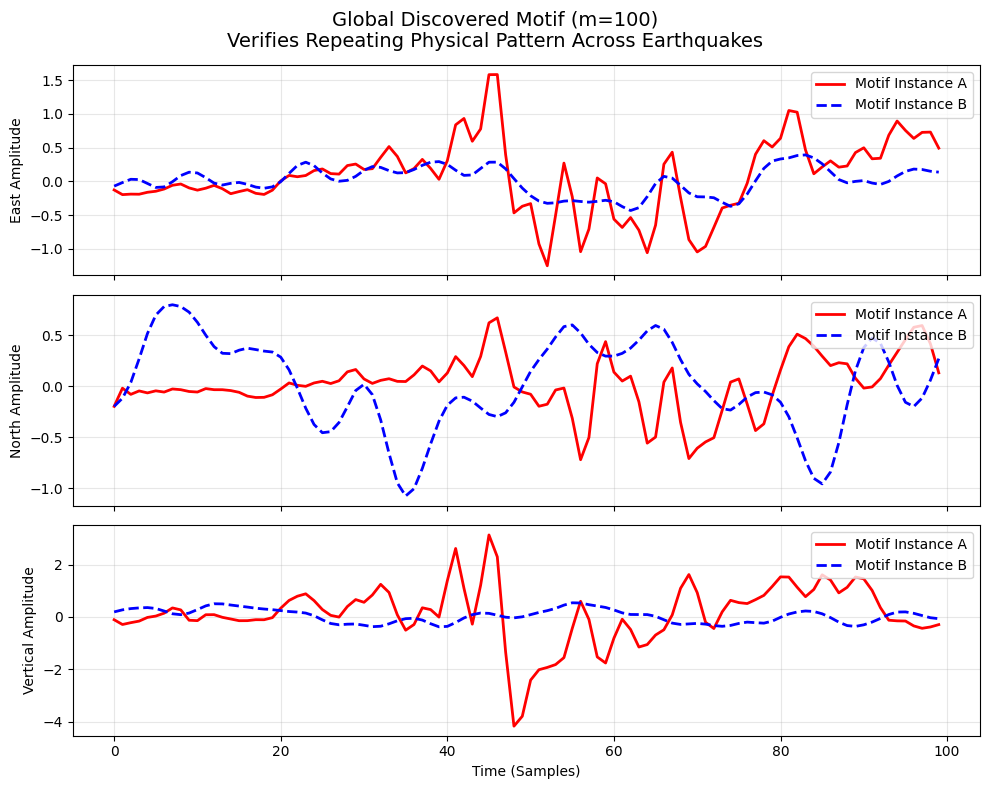


--- Mining Motifs with Window Size m=200 ---
Running MSTUMP on 240000 samples...
Global Motif Found! Distance: 12.7269


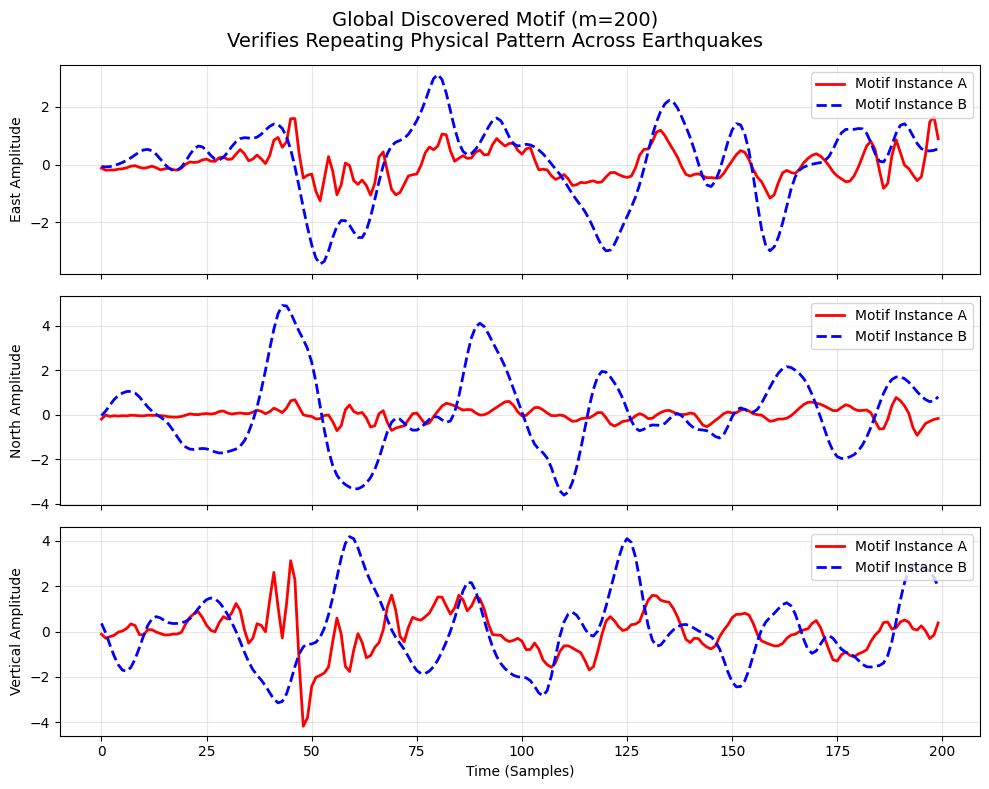


Processing Complete. Check the 'global_motif' plots.


In [33]:
import stumpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os

# ================================================================
# 1. SETUP & PARAMETERS
# ================================================================
# We analyze a BATCH of signals to find patterns ACROSS earthquakes
BATCH_SIZE = 200    # Top 100 High-SNR signals (Sufficient for mining)
MOTIF_LENGTHS = [100, 200]  # Focused on physically relevant lengths (1s, 2s)
# Note: m=1000 is removed because it equals the signal length (invalid for mining)

# Create Output Dir
save_dir = "motif_results_corrected"
os.makedirs(save_dir, exist_ok=True)

# 2. PREPARE DATA (CONCATENATION STRATEGY)
# ----------------------------------------------------------------
# We assume 'signal_data' is (N, 3, 1000) and 'metadata' is available
# Sort by SNR to get the cleanest data for mining
print("Selecting Top High-SNR Signals...")
top_indices = metadata.sort_values('snr_db_E', ascending=False).index[:BATCH_SIZE]
subset = signal_data[top_indices] # Shape (100, 3, 1000)

# ================================================================
# 3. LOOP OVER MOTIF LENGTHS
# ================================================================
for m in MOTIF_LENGTHS:
    print(f"\n--- Mining Motifs with Window Size m={m} ---")
    
    # A. CONCATENATE WITH SPACERS
    # We stitch the 100 signals into one long series with NaN spacers
    # to prevent matching across boundaries.
    spacers = np.full((BATCH_SIZE, 3, m), np.nan)
    # Shape: (100, 3, 1100) -> Flattened later
    combined = np.concatenate((subset, spacers), axis=2) 
    
    # Transpose for Stumpy: Needs (Time, Dimensions)
    # New Shape: (110000, 3)
    long_signal = combined.transpose(0, 2, 1).reshape(-1, 3)
    df_long = pd.DataFrame(long_signal, columns=['E', 'N', 'Z'])

    # B. RUN MULTIDIMENSIONAL STUMP (CPU is fine for this size)
    print(f"Running MSTUMP on {len(df_long)} samples...")
    mp, indices = stumpy.mstump(df_long, m)
    
    # C. EXTRACT THE TOP GLOBAL MOTIFS
    # Find the single best motif (lowest distance) across all 100 quakes
    motif_idx = np.argmin(mp[:, 0])      # Index of best motif (Occurrence 1)
    nearest_idx = indices[motif_idx, 0]  # Index of its match (Occurrence 2)
    
    print(f"Global Motif Found! Distance: {mp[motif_idx, 0]:.4f}")

    # D. VISUALIZE THE DISCOVERED PATTERN
    # We plot the top motif found to see if it matches the 'P-Coda' physics
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    channels = ['East', 'North', 'Vertical']
    for i, ch in enumerate(channels):
        # Extract the motif shape
        # Occurrence A
        seq_a = df_long.iloc[motif_idx : motif_idx+m, i].values
        # Occurrence B
        seq_b = df_long.iloc[nearest_idx : nearest_idx+m, i].values
        
        # Plot
        axes[i].plot(seq_a, 'r-', lw=2, label='Motif Instance A')
        axes[i].plot(seq_b, 'b--', lw=2, label='Motif Instance B')
        axes[i].set_ylabel(f"{ch} Amplitude")
        axes[i].legend(loc="upper right")
        axes[i].grid(True, alpha=0.3)
    
    axes[2].set_xlabel("Time (Samples)")
    plt.suptitle(f"Global Discovered Motif (m={m})\nVerifies Repeating Physical Pattern Across Earthquakes", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/global_motif_m{m}.png")
    plt.show()

print("\nProcessing Complete. Check the 'global_motif' plots.")

In [10]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'source_origin_time', 'trace_start_time', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_travel_sec', 's_arrival_sample', 's_status', 'source_id',
       'source_latitude', 'source_longitude', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type', 'source_distance_km',
       'back_azimuth_deg', 'coda_end_sample', 'id', 'norm_s_arrival_sample',
       'snr_db_E', 'snr_db_N', 'snr_db_V'],
      dtype='object')

In [11]:
import stumpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Use notebook version for Jupyter

def mine_seismic_motifs(signal_data, metadata, filters, m=100, top_n=50):
    """
    Mines for a global recurring motif across a subset of earthquakes.
    
    Parameters:
    - signal_data: (N, 3, 1000) numpy array of waveforms
    - metadata: (N, ) pandas DataFrame corresponding to signals
    - filters: dict of column_name -> (min, max) or exact_value
    - m: window size (default 100 samples = 1 second)
    - top_n: Number of signals to process (to keep CPU time reasonable)
    """
    
    # --- STEP 1: FILTERING ---
    print(f"🔍 Applying Filters to {len(metadata)} signals...")
    df_subset = metadata.copy()
    
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):  # Range (min, max)
            df_subset = df_subset[
                (df_subset[col] >= criteria[0]) & 
                (df_subset[col] <= criteria[1])
            ]
        else:  # Exact Match (e.g., Station Code)
            df_subset = df_subset[df_subset[col] == criteria]
            
    print(f"   -> {len(df_subset)} signals matched criteria.")
    
    if len(df_subset) < 2:
        print("❌ Not enough signals to find a pattern! Relax your filters.")
        return
    
    # Sort by SNR (East channel) to get the cleanest remaining signals
    df_subset = df_subset.sort_values('snr_db_E', ascending=False).head(top_n)
    subset_indices = df_subset.index.to_numpy()
    
    print(f"   -> Selected top {len(df_subset)} High-SNR signals for mining.")

    # --- STEP 2: PREPARE DATA (Concatenation) ---
    # Extract the actual waveform arrays
    waveforms = signal_data[subset_indices]  # Shape: (top_n, 3, 1000)
    
    # Create NaNs spacers to separate earthquakes
    # Shape: (top_n, 3, m)
    spacers = np.full((len(df_subset), 3, m), np.nan)
    
    # Concatenate: Signal -> Spacer -> Signal -> Spacer...
    # We concat along axis 2 (time axis)
    combined = np.concatenate((waveforms, spacers), axis=2)
    
    # Flatten for Stumpy: (Total_Time, 3)
    # Transpose (N, 3, T) -> (N, T, 3) then flatten N*T
    long_signal = combined.transpose(0, 2, 1).reshape(-1, 3)
    
    # Convert to DataFrame (Stumpy expects this for multidimensional)
    df_stumpy = pd.DataFrame(long_signal, columns=['East', 'North', 'Vertical'])
    
    # --- STEP 3: RUN MSTUMP ---
    print(f"⚙️ Running Matrix Profile (m={m})...")
    # This might take 10-60 seconds depending on top_n
    mp, indices = stumpy.mstump(df_stumpy, m)
    
    # --- STEP 4: EXTRACT BEST MOTIF ---
    # The global minimum of the matrix profile is the "Best Motif"
    # We check the first dimension (mp[:, 0]) for the lowest distance
    best_idx = np.nanargmin(mp[:, 0])
    nearest_idx = indices[best_idx, 0]
    min_dist = mp[best_idx, 0]
    
    print(f"✅ Pattern Found! Distance: {min_dist:.4f}")
    
    # --- STEP 5: VISUALIZATION ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    channels = ['East', 'North', 'Vertical']
    
    for i, ax in enumerate(axes):
        # Extract the shapes
        query = df_stumpy.iloc[best_idx : best_idx+m, i].values
        match = df_stumpy.iloc[nearest_idx : nearest_idx+m, i].values
        
        ax.plot(query, color=colors[i], label=f'Motif A (Idx {best_idx})', linewidth=2)
        ax.plot(match, color='red', linestyle='--', label=f'Motif B (Idx {nearest_idx})', alpha=0.8)
        ax.set_ylabel(f"{channels[i]} Amplitude")
        ax.legend(loc="upper right")
        ax.grid(True, alpha=0.3)
    
    axes[2].set_xlabel("Samples (Time)")
    plt.suptitle(f"Top Consensus Motif (m={m})\nFilters: {filters}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return df_subset  # Return the metadata of the signals used

In [15]:
metadata['p_status'].describe()

count      29871
unique         3
top       manual
freq       28876
Name: p_status, dtype: object

In [21]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'source_origin_time', 'trace_start_time', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_travel_sec', 's_arrival_sample', 's_status', 'source_id',
       'source_latitude', 'source_longitude', 'source_depth_km',
       'source_magnitude', 'source_magnitude_type', 'source_distance_km',
       'back_azimuth_deg', 'coda_end_sample', 'id', 'norm_s_arrival_sample',
       'snr_db_E', 'snr_db_N', 'snr_db_V'],
      dtype='object')

🔍 Applying Filters to 29871 signals...
   -> 36 signals matched criteria.
   -> Selected top 36 High-SNR signals for mining.
⚙️ Running Matrix Profile (m=100)...
✅ Pattern Found! Distance: 9.3411


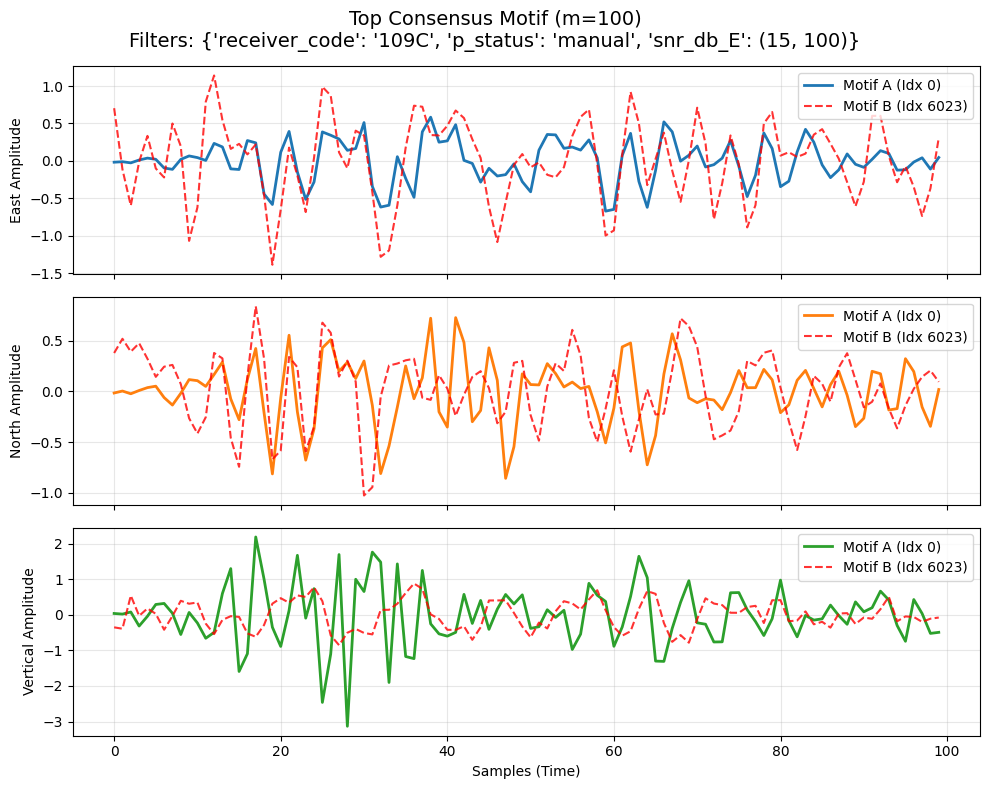

In [20]:
# Define your filters
my_filters = {
    'receiver_code': '109C',       # Focus on one station (from your example data)
    'p_status': 'manual',          # Only use verified human picks
    'snr_db_E': (15, 100)          # Ensure decent signal quality
}

# Run the function
used_data = mine_seismic_motifs(
    signal_data=signal_data, 
    metadata=metadata, 
    filters=my_filters, 
    m=100,      # 1 second window
    top_n=50    # Analyze top 50 matches (fast)
)

In [22]:
import stumpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mine_motifs_with_paa(signal_data, metadata, filters, m=100, paa_factor=4, top_n=1000):
    """
    Mines for motifs using PAA for speed.
    
    Parameters:
    - paa_factor: Compression ratio (e.g., 4 means 1000 points -> 250 points)
    - m: ORIGINAL window size (e.g., 100). The function will shrink this automatically.
    """
    
    # --- STEP 1: FILTERING ---
    print(f"🔍 Filtering metadata...")
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    # Sort by SNR and limit count
    df_subset = df_subset.sort_values('snr_db_E', ascending=False).head(top_n)
    subset_indices = df_subset.index.to_numpy()
    print(f"   -> Processing {len(df_subset)} signals (PAA Factor: {paa_factor}x)")

    # --- STEP 2: PAA COMPRESSION ---
    # Extract raw waveforms: (N, 3, 1000)
    raw_waves = signal_data[subset_indices]
    
    # Perform PAA (Mean of segments)
    # New length = 1000 / paa_factor
    n_original = raw_waves.shape[2]
    n_new = n_original // paa_factor
    
    # Reshape and Mean to compress: (N, 3, New_Len, Factor) -> Mean over Factor axis
    compressed_waves = raw_waves.reshape(len(df_subset), 3, n_new, paa_factor).mean(axis=3)
    
    # Adjust Window Size 'm'
    m_compressed = int(m / paa_factor)
    print(f"   -> Signal Length: {n_original} -> {n_new}")
    print(f"   -> Window Size (m): {m} -> {m_compressed}")

    # --- STEP 3: PREPARE FOR STUMPY ---
    # Create spacers (NaNs) of the NEW length
    spacers = np.full((len(df_subset), 3, m_compressed), np.nan)
    
    # Concatenate
    combined = np.concatenate((compressed_waves, spacers), axis=2)
    
    # Flatten: (N, 3, T) -> (N, T, 3) -> (Total_T, 3)
    long_signal = combined.transpose(0, 2, 1).reshape(-1, 3)
    df_stumpy = pd.DataFrame(long_signal, columns=['East', 'North', 'Vertical'])
    
    # --- STEP 4: RUN MSTUMP ---
    print(f"⚙️ Running Matrix Profile (Compressed)...")
    mp, indices = stumpy.mstump(df_stumpy, m_compressed)
    
    # --- STEP 5: MAPPING BACK TO ORIGINAL ---
    # We found the motif in compressed space, but we want to plot the HIGH RES version
    best_idx_compressed = np.nanargmin(mp[:, 0])
    nearest_idx_compressed = indices[best_idx_compressed, 0]
    
    # Convert compressed index back to original index
    # We need to handle the spacers carefully in the math, but for visualization
    # it is easier to just map the "Signal Index" and "Relative Offset"
    
    def get_original_location(flat_idx, n_small, m_small, spacer_small):
        total_block = n_small + spacer_small
        trace_id = flat_idx // total_block
        offset = flat_idx % total_block
        return trace_id, offset * paa_factor # Scale offset back up

    trace_a, start_a = get_original_location(best_idx_compressed, n_new, m_compressed, m_compressed)
    trace_b, start_b = get_original_location(nearest_idx_compressed, n_new, m_compressed, m_compressed)
    
    print(f"✅ Motif Found in Trace #{trace_a} and Trace #{trace_b}")

    # --- VISUALIZATION (HIGH RES) ---
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    channels = ['East', 'North', 'Vertical']
    
    for i, ax in enumerate(axes):
        # Plotting the ORIGINAL RAW data, not the PAA data
        wave_a = raw_waves[trace_a, i, :]
        wave_b = raw_waves[trace_b, i, :]
        
        # Plot the whole signal in grey
        ax.plot(wave_a, color='lightgrey', alpha=0.5)
        
        # Highlight the motif in color
        # Note: We use the original 'm' here
        motif_slice_a = np.arange(start_a, start_a + m)
        motif_slice_b = np.arange(start_b, start_b + m)
        
        # Boundary check
        if motif_slice_a[-1] < 1000:
            ax.plot(motif_slice_a, wave_a[motif_slice_a], color='tab:red', lw=2, label="Motif A (High Res)")
        if motif_slice_b[-1] < 1000:
            ax.plot(motif_slice_b, wave_b[motif_slice_b], color='tab:blue', ls='--', lw=2, label="Motif B (High Res)")
            
        ax.set_ylabel(channels[i])
        ax.legend(loc="upper right")
    
    plt.suptitle(f"Motif Discovery via PAA (Factor {paa_factor}x)\nOriginal Resolution Visualization", fontsize=14)
    plt.tight_layout()
    plt.show()

<Axes: >

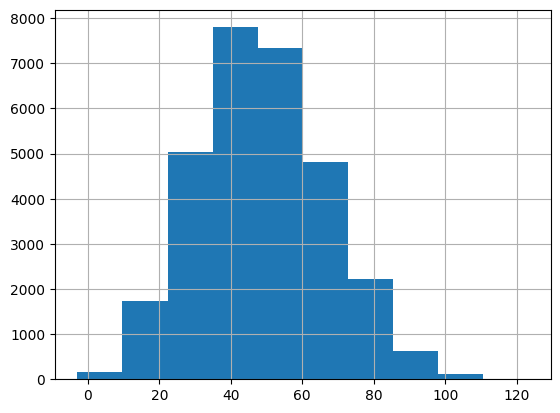

In [28]:
metadata['snr_db_E'].hist()

🔍 Filtering metadata...
   -> Processing 50 signals (PAA Factor: 4x)
   -> Signal Length: 1000 -> 250
   -> Window Size (m): 100 -> 25
⚙️ Running Matrix Profile (Compressed)...
✅ Motif Found in Trace #0 and Trace #28


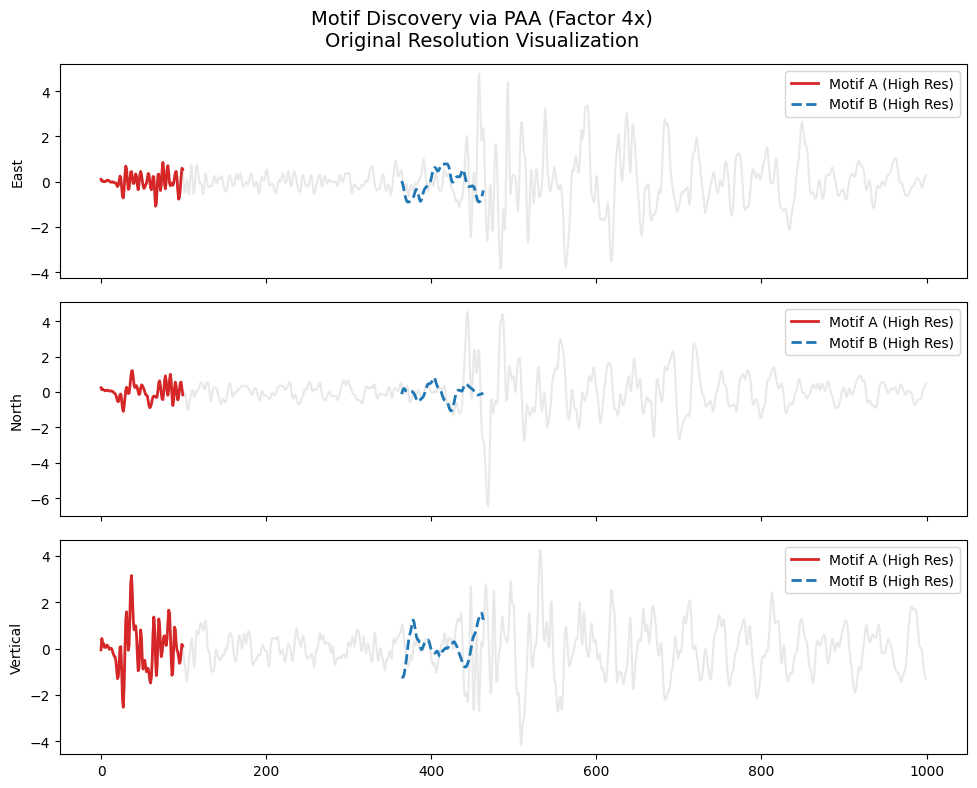

In [ ]:
filters = {
    'snr_db_E': (15, 100)
}

# Run with 4x compression
mine_motifs_with_paa(signal_data, metadata, filters, m=100, paa_factor=2, top_n=200)

In [15]:
import stumpy
from stumpy import gpu_stump
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mine_motifs_gpu(signal_data, metadata, filters, m=100, top_n=5000):
    """
    Mines for motifs using NVIDIA GPU (1-Dimensional, East Channel).
    
    Parameters:
    - m: Window size (default 100 samples = 1 second)
    - top_n: Number of signals to process (RTX 3090 can handle 5000+ easily)
    """
    
    # --- STEP 1: FILTERING ---
    print(f"🔍 Filtering metadata...")
    df_subset = metadata.copy()
    for col, criteria in filters.items():
        if isinstance(criteria, tuple):
            df_subset = df_subset[(df_subset[col] >= criteria[0]) & (df_subset[col] <= criteria[1])]
        else:
            df_subset = df_subset[df_subset[col] == criteria]
    
    # Sort by SNR and limit count
    df_subset = df_subset.sort_values('snr_db_E', ascending=False).head(top_n)
    subset_indices = df_subset.index.to_numpy()
    print(f"   -> Processing {len(df_subset)} signals on RTX 3090 🚀")

    # --- STEP 2: DATA PREPARATION (NO PAA NEEDED) ---
    # We use FULL RESOLUTION because the GPU is powerful
    # Extract only East Channel (Index 0) for 1D analysis
    raw_waves = signal_data[subset_indices, 0, :]  # Shape: (N, 1000)
    
    # Create spacers (NaNs)
    spacers = np.full((len(df_subset), m), np.nan)
    
    # Concatenate: Signal -> Spacer -> Signal...
    combined = np.hstack([raw_waves, spacers])
    
    # Flatten to 1D array for GPU
    long_signal = combined.flatten().astype(np.float64) # GPU requires float64
    
    print(f"   -> Total Time Series Length: {len(long_signal):,} points")

    # --- STEP 3: RUN GPU STUMP ---
    print(f"⚙️ Running GPU Matrix Profile (m={m})...")
    
    # Using gpu_stump (1D)
    mp = gpu_stump(long_signal, m=m)
    
    # --- STEP 4: EXTRACT RESULTS ---
    # Column 0 = Distance, Column 1 = Nearest Neighbor Index
    best_idx = np.argmin(mp[:, 0])
    nearest_idx = int(mp[best_idx, 1])
    min_dist = mp[best_idx, 0]
    
    # Map back to original trace ID
    def get_trace_location(flat_idx, signal_len, spacer_len):
        total_block = signal_len + spacer_len
        trace_id = flat_idx // total_block
        offset = flat_idx % total_block
        return trace_id, offset

    trace_a, start_a = get_trace_location(best_idx, 1000, m)
    trace_b, start_b = get_trace_location(nearest_idx, 1000, m)
    
    print(f"✅ GPU Pattern Found! Distance: {min_dist:.4f}")
    print(f"   Trace #{trace_a} matches Trace #{trace_b}")

    # --- VISUALIZATION ---
    plt.figure(figsize=(10, 4))
    
    # Extract waveforms
    wave_a = signal_data[subset_indices[trace_a], 0, :]
    wave_b = signal_data[subset_indices[trace_b], 0, :]
    
    # Plot Context (Grey)
    plt.plot(wave_a, color='lightgrey', alpha=0.5, label='Trace A Context')
    
    # Plot Motifs (Red/Blue)
    motif_a = wave_a[start_a : start_a + m]
    motif_b = wave_b[start_b : start_b + m]
    
    plt.plot(np.arange(start_a, start_a+m), motif_a, color='tab:red', lw=2, label='Motif A')
    plt.plot(np.arange(start_b, start_b+m), motif_b, color='tab:blue', ls='--', lw=2, label='Motif B')
    
    plt.title(f"RTX 3090 Discovery (East Channel Only, m={m})\nMatched Pattern Across Earthquakes")
    plt.xlabel("Time (Samples)")
    plt.ylabel("East Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_subset

🔍 Filtering metadata...
   -> Processing 1000 signals on RTX 3090 🚀
   -> Total Time Series Length: 1,100,000 points
⚙️ Running GPU Matrix Profile (m=100)...
✅ GPU Pattern Found! Distance: 0.0000
   Trace #453 matches Trace #557


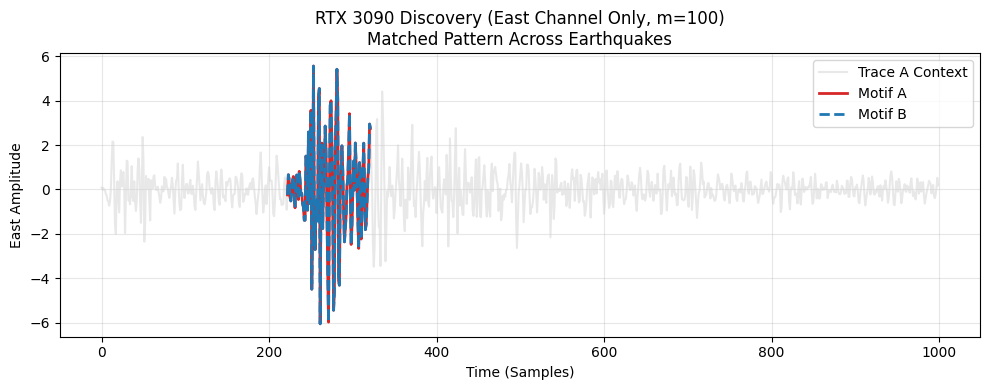

,trace_name,network_code,receiver_code,receiver_type,source_origin_time,trace_start_time,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,...,source_magnitude,source_magnitude_type,source_distance_km,back_azimuth_deg,coda_end_sample,id,norm_s_arrival_sample,snr_db_E,snr_db_N,snr_db_V
4487,BLA2.CI_20160610080445_EV,CI,BLA2,HH,2016-06-10 08:04:38.700000,2016-06-10 08:04:45.600000,34.06931,-116.38993,1247.0,500.0,...,5.2,mw,70.78,183.900,2473,557137,435,100.000000,103.599998,95.699997
16576,M12A.TA_20080401131616_EV,TA,M12A,BH,2008-04-01 13:16:18.20,2008-04-01 13:16:17.550000,41.41570,-114.91510,1930.0,400.0,...,4.3,mb,26.35,345.300,2096,936160,191,99.900002,95.199997,74.699997
24154,SHP.NN_20150522184749_EV,NN,SHP,HH,2015-05-22 18:47:42.980000,2015-05-22 18:47:49.521390,36.50470,-115.15670,1632.0,900.0,...,5.3,ml,98.12,27.160,3319,1143675,551,99.800003,99.900002,96.699997
17724,MONP2.AZ_20160610080442_EV,AZ,MONP2,HH,2016-06-10 08:04:38.700000,2016-06-10 08:04:42.000000,32.89200,-116.42230,1875.0,700.0,...,5.2,mw,59.75,358.200,2347,971631,457,99.699997,101.000000,102.300003
27180,TRF.AK_20110123025000_EV,AK,TRF,BH,2011-01-23 02:50:05.52,2011-01-23 02:50:01.360000,63.45020,-150.28930,1711.9,900.0,...,5.2,mw,27.50,104.200,5900,1199380,81,99.699997,92.300003,91.400002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13463,ITM.HL_20080106051430_EV,HL,ITM,SH,2008-01-06 05:14:21.03,2008-01-06 05:14:31.800000,37.17872,21.92522,423.0,400.0,...,6.2,mw,69.64,263.100,5400,849980,242,82.400002,99.400002,87.800003
29222,WAT2.AK_20140924073116_EV,AK,WAT2,BH,2014-09-24 07:30:56.15,2014-09-24 07:31:17.890000,62.96280,-148.58550,1366.0,800.0,...,4.5,mb,203.42,332.400,5900,1233519,465,82.300003,76.099998,75.199997
17762,MPI.CI_20150104031811_EV,CI,MPI,HH,2015-01-04 03:18:09.62,2015-01-04 03:18:12.140000,34.81258,-119.14530,2673.0,600.0,...,4.2,mb,52.82,295.600,3397,972478,228,82.300003,83.400002,76.400002
1419,AMKA.AV_20140624151513_EV,AV,AMKA,BH,2014-06-24 15:15:04.330000,2014-06-24 15:15:13.240000,51.37710,179.30000,116.0,1000.0,...,4.6,mb,79.99,311.632,3282,261209,582,82.300003,81.900002,72.400002


In [17]:
filters = {
    'snr_db_E': (15, 100)
}


mine_motifs_gpu(signal_data,metadata,filters,m=100, top_n=1000)

In [14]:
# quick monkeypatch workaround (temporary)
try:
    import numba.cuda.codegen as _ncg
    if not hasattr(_ncg.CUDACodeLibrary, "_reload_init"):
        # add a shared set so instance._reload_init.update(...) will work
        _ncg.CUDACodeLibrary._reload_init = set()
except Exception:
    # ignore if module not present yet / broken
    pass

# then import stumpy
import stumpy


# Code Explanation

## 1. Motif Extraction

Using **multidimensional matrix profiles (mstump)**, a representative motif was extracted from every signal across all three channels. These motifs served as compressed, shape-based descriptors of the dominant local pattern within each waveform.

## 2. Automatic Cluster Selection

For each motif length, we performed a systematic evaluation of candidate cluster numbers using:

* **Within-cluster SSE (Elbow)**
* **Silhouette Score**
* **Calinski–Harabasz Index**

The optimal number of clusters was determined by combining these metrics via a median-vote heuristic.
For the 1000-step motifs, the best value converged to **k = 8 clusters**, indicating that the dataset contains approximately eight distinct characteristic waveform shapes.

## 3. Cluster Structure and Centroid Patterns

The cluster visualizations show each cluster's centroid (black curve) along with a large number of motif samples overlaid with transparency. Several strong trends emerged:

### (a) Cluster Size Variation

Clusters vary significantly in population:

* Largest clusters contain **5000–6000 signals**
* Smallest clusters contain **2500–3000 signals**

This indicates that certain motif shapes occur far more frequently in the dataset.

### (b) High Within-Cluster Agreement

Many clusters display extremely tight overlay around the centroid, especially in:

* **Channel 1** and **Channel 2**
* The **mid-segment region** (≈ 300–800)

This consistency suggests that the motifs capture a robust and repeated structural pattern in the underlying signals.

### (c) Presence of Noise-Dominated Clusters

A few clusters exhibit:

* Larger variance envelopes
* Weakly defined centroid features
* High variability in amplitude

These clusters likely correspond to **noisy signals**, **non-standard events**, or motifs that do not contain the canonical structure seen elsewhere.

### (d) Multi-Channel Synchrony

Across all clusters, the three channels tend to share:

* Similar peak timings
* Similar decay phases
* Aligned transient features

This validates that the motifs are capturing a **coherent multivariate event** rather than unrelated channel-specific fluctuations.

### (e) Distinctive Onset Characteristics

The main differences between clusters arise from:

* Amplitude and sign of the initial transient (first ~150 samples)
* Strength of the peak around the motif center (~400–600 samples)
* Noise level and decay slope in the final third

These distinctions allow the clustering to separate signals not only by shape but also by subtle temporal dynamics.

## 4. PCA Visualization

PCA 2D and 3D projections show clearly separable cluster groups.
Most clusters form well-bounded ellipsoidal clouds, supporting that:

* The centroid shapes represent **distinct waveform families**

Some overlaps occur between noise-heavy clusters, consistent with the less defined centroid structures observed.



# Results

- We applied multidimensional motif discovery and clustering to a dataset of **three-channel seismic signals** using motif lengths of 100, 200, 500, and 1000 time steps.

## m=100
- For m=100, the motifs we're not significant. This is expected since m=100 is insufficient for capturing a global pattern among all the series.
- Also the cluster centroids are not too descriptive, they correspond to flat lines.

## m=200
- Same situation with m=100 happens again with m=200. The clusters do not distribute evenly and cluster centroids do not show a significant pattern.

## m=500

- Our algorithm which runs via Elbow method has extracted two clusters. Cluster 0 shows a magnitude flow similar to negative log(x) plot. This cluster represents the %12 of our signals. It shows a noisy yet descriptive shapelet.

- Cluster 1 contains the rest. Since these signals could not be seperated into more clusters, this cluster shows a noisy behaviour. This unfortunately is not informative in our analysis.

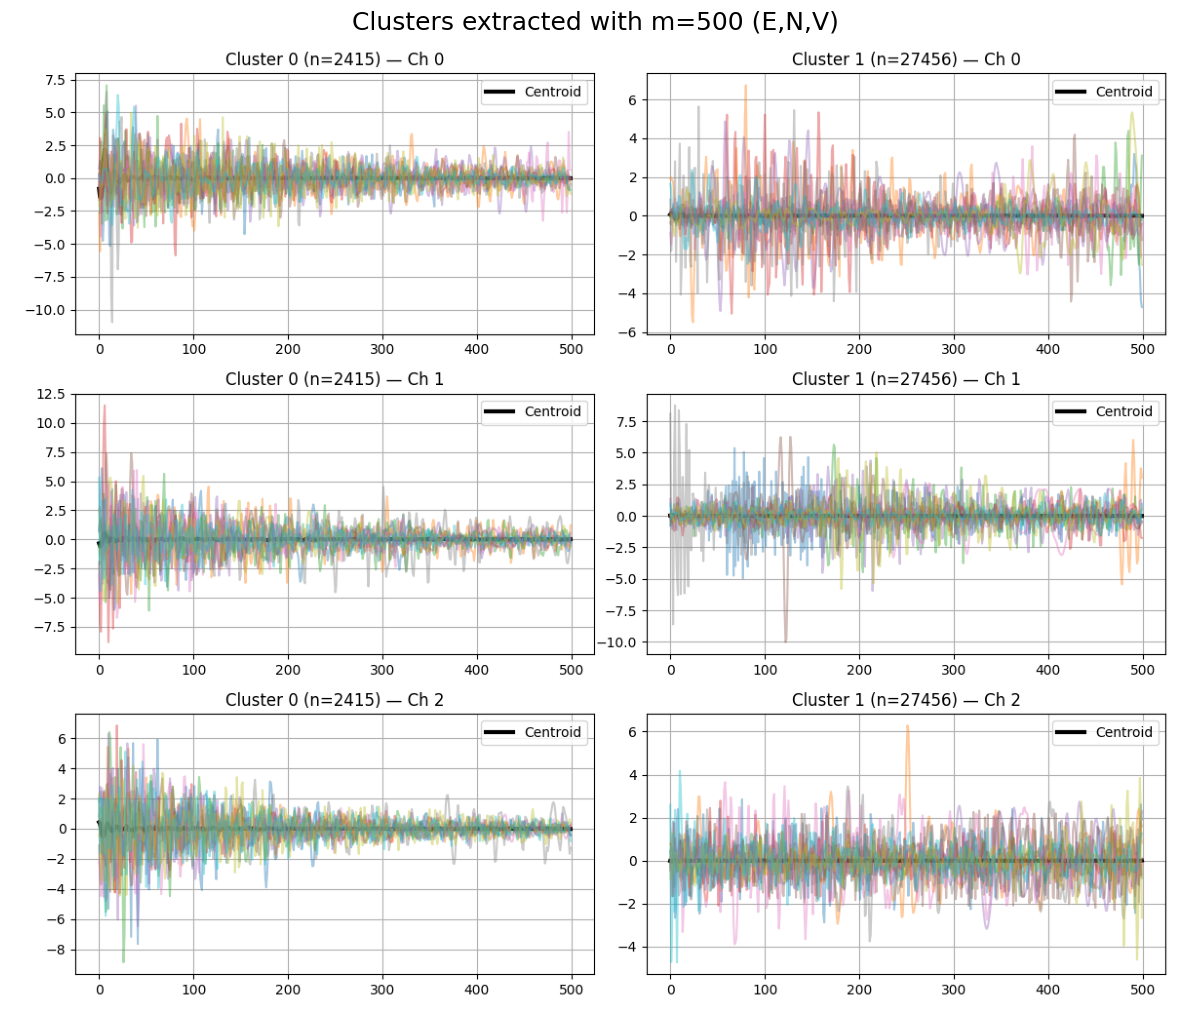

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_E = mpimg.imread("motif_results_stumpy\m_500\clusters_m500.png")


# Plot BIG images with colorful colormap
plt.figure(figsize=(12, 12))

plt.imshow(img_E)
plt.title("Clusters extracted with m=500 (E,N,V)", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


## m=1000

- This experiment is the most informative one ever conducted in terms of this work.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img_E = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-E_channel_0.png")
img_N = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-N_channel_1.png")
img_V = mpimg.imread("sax/plots/segment200_bin24_strategy-quantile_channel-V_channel_2.png")

# Plot BIG images with colorful colormap
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.imshow(img_E)
plt.title("Channel E", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(img_N)
plt.title("Channel N", fontsize=18)
plt.axis('off')

plt.subplot(3, 1, 3)
plt.imshow(img_V)
plt.title("Channel V", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()


 The results reported here focus on the **1000-length motifs**, which produced the most stable and interpretable cluster structures.